<h1>Week 8: ARIMA-Models</h1>

<br>
1 Autoregressive- (AR) and Moving Average (MA) models<br>
2 Predicting with ARMA und ARIMA models<br>
3 Considering seasonality with SARIMA models<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [40]:
em = pd.read_csv("em_HH60_2012_05.csv", index_col=0)
em['Time'] = pd.to_datetime(em['Time'])
em.set_index('Time', inplace=True)
em.index.freq = 'H'
em.head()

,Electricity
Time,
2012-05-01 00:00:00,514.0
2012-05-01 01:00:00,434.0
2012-05-01 02:00:00,528.0
2012-05-01 03:00:00,538.0
2012-05-01 04:00:00,507.0


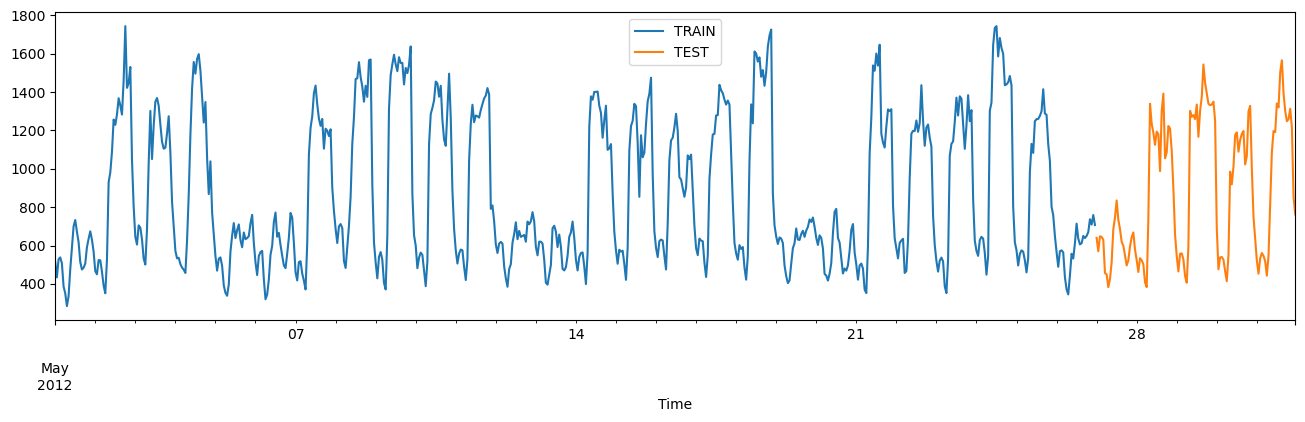

In [41]:
train_em = em[:624]
test_em = em[624:]
train_em['Electricity'].plot(legend=True,label='TRAIN')
test_em['Electricity'].plot(legend=True,label='TEST',figsize=(16,4));

<h3> Naiv One Step</h3>

In [42]:
train_em.tail()

,Electricity
Time,
2012-05-26 19:00:00,670.0
2012-05-26 20:00:00,737.0
2012-05-26 21:00:00,709.0
2012-05-26 22:00:00,759.0
2012-05-26 23:00:00,707.0


In [43]:
naiv = pd.DataFrame()
naiv = naiv.reindex_like(test_em)
#naiv = naiv.assign('Strom'==last)
naiv['Electricity'] = train_em.iloc[623]['Electricity']
naiv.columns = ['Naive Prediction']
naiv.head()

,Naive Prediction
Time,
2012-05-27 00:00:00,707.0
2012-05-27 01:00:00,707.0
2012-05-27 02:00:00,707.0
2012-05-27 03:00:00,707.0
2012-05-27 04:00:00,707.0


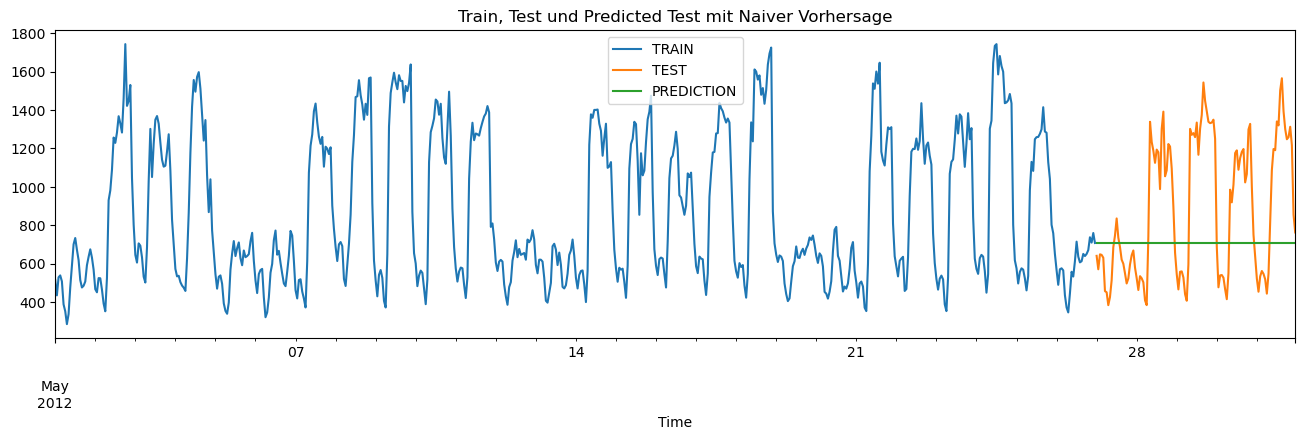

In [44]:
train_em['Electricity'].plot(legend=True,label='TRAIN')
test_em['Electricity'].plot(legend=True,label='TEST',figsize=(16,4))
naiv['Naive Prediction'].plot(legend=True,label='PREDICTION')
plt.title('Train, Test und Predicted Test mit Naiver Vorhersage');

<h3> ARIMA models: Can we apply this method? </h3>

Is our time series stationary?<br>
Dickey-Fuller-Test (null hypothesis: not stationary)

In [45]:
testresults = adfuller(train_em)
print("Test statistic = {:.2f}".format(testresults[0]))
print("p-Value = {:.2f}".format(testresults[1]))
print("Number of lags = {:.2f}".format(testresults[2]))
print("Number of observations = {:.2f}".format(testresults[3]))
print("Critical value at 1% = {:.2f}".format(testresults[4]["1%"]))
print("Critical value at 5% = {:.2f}".format(testresults[4]["5%"]))
print("Critical value at 10% = {:.2f}".format(testresults[4]["10%"]))

Test statistic = -3.38
p-Value = 0.01
Number of lags = 19.00
Number of observations = 604.00
Critical value at 1% = -3.44
Critical value at 5% = -2.87
Critical value at 10% = -2.57


In [46]:
testresults = adfuller(train_em)
print("Test statistic = {:.2f}".format(testresults[0]))
print("p-Value = {:.2f}".format(testresults[1]))

Test statistic = -3.38
p-Value = 0.01


<h3> ARIMA models: determine p,d,q, P,D,Q, m </h3>

<h3>Geometric information from the ACF and PACF function</h3>

The ACF and PACF curves should be considered together to define the process. For an AR process, we expect the ACF curve to gradually decrease and at the same time the PACF curve to show a sharp drop after p significant delays. To define an MA process, we expect the ACF and PACF graphs to show the opposite, i.e., the ACF should show a sharp drop after a certain number q of lags, while the PACF should show a geometric or gradually decreasing trend. On the other hand, if both the ACF and PACF curves show a gradually decreasing pattern, then the ARMA process should be considered for modeling.

We can select the order p for the AR(p) model based on significant spikes from the PACF diagram. Anything outside the blue boundary of the PACF diagram gives an indication of the order of the AR model.

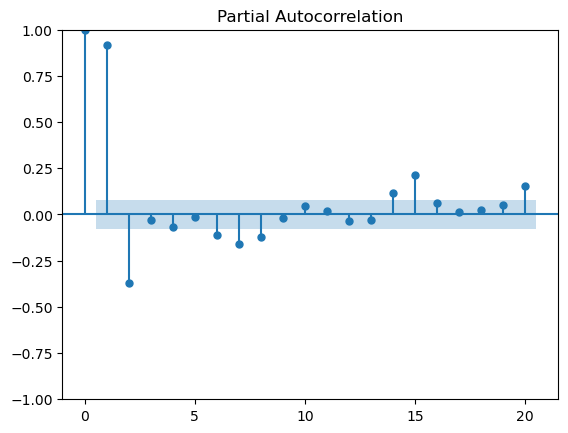

In [47]:
plot_pacf(train_em, lags=20, method='ywm');

In [50]:
for_mod = SARIMAX(train_em, 
              order=(2, 0, 0))
for_results = for_mod.fit()
print(for_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3093      0.040     33.142      0.000       1.232       1.387
ar.L2         -0.3273      0.041     -7.928      0.000      -0.408      -0.246
sigma2      2.103e+04    622.340     33.785      0.000    1.98e+04    2.22e+04


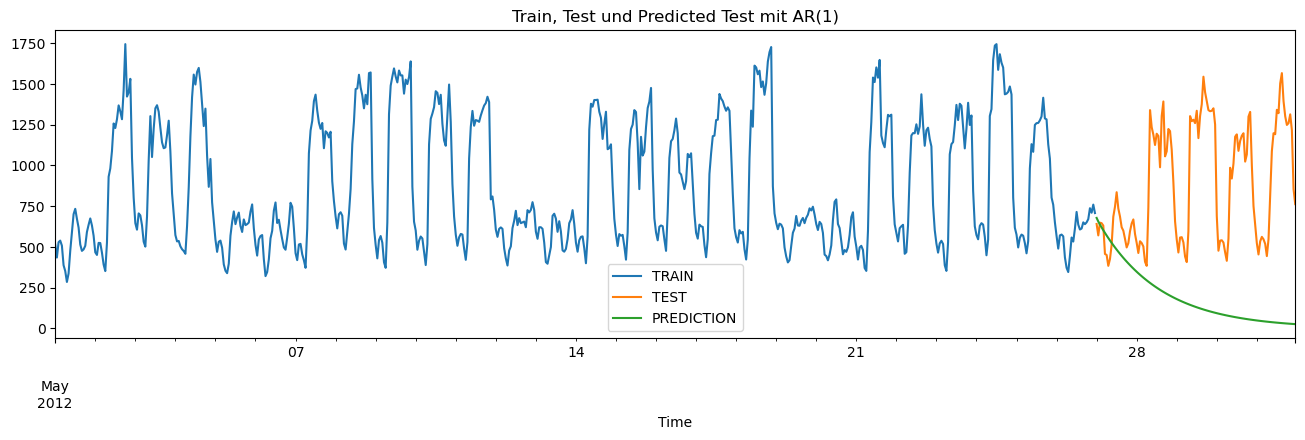

In [51]:
for_pred = for_results.get_forecast(steps=120)
train_em['Electricity'].plot(legend=True,label='TRAIN')
test_em['Electricity'].plot(legend=True,label='TEST',figsize=(16,4))
for_pred.predicted_mean.plot(legend=True,label='PREDICTION')
plt.title('Train, Test und Predicted Test mit AR(1)');

Im Gegensatz zum AR-Modell kann die Ordnung q für das Modell MA(q) aus dem ACF ausgewählt werden, wenn dieses Diagramm einen scharfen Cut-off nach dem Lag q aufweist.

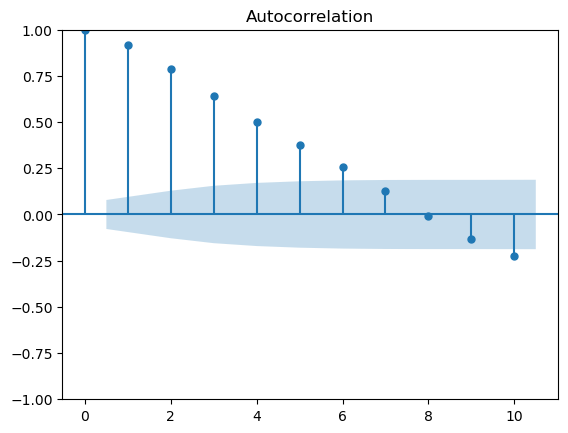

In [52]:
plot_acf(train_em, lags=10);

In [64]:
warnings.filterwarnings("ignore")
for_mod = SARIMAX(train_em, 
              order=(2, 0, 0))
for_results = for_mod.fit()
print(for_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3093      0.040     33.142      0.000       1.232       1.387
ar.L2         -0.3273      0.041     -7.928      0.000      -0.408      -0.246
sigma2      2.103e+04    622.340     33.785      0.000    1.98e+04    2.22e+04


In [57]:
for_mod = SARIMAX(train_em, 
              order=(1, 0, 1))
for_results = for_mod.fit()
print(for_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9790      0.008    127.168      0.000       0.964       0.994
ma.L1          0.3254      0.039      8.314      0.000       0.249       0.402
sigma2      2.116e+04    639.438     33.098      0.000    1.99e+04    2.24e+04


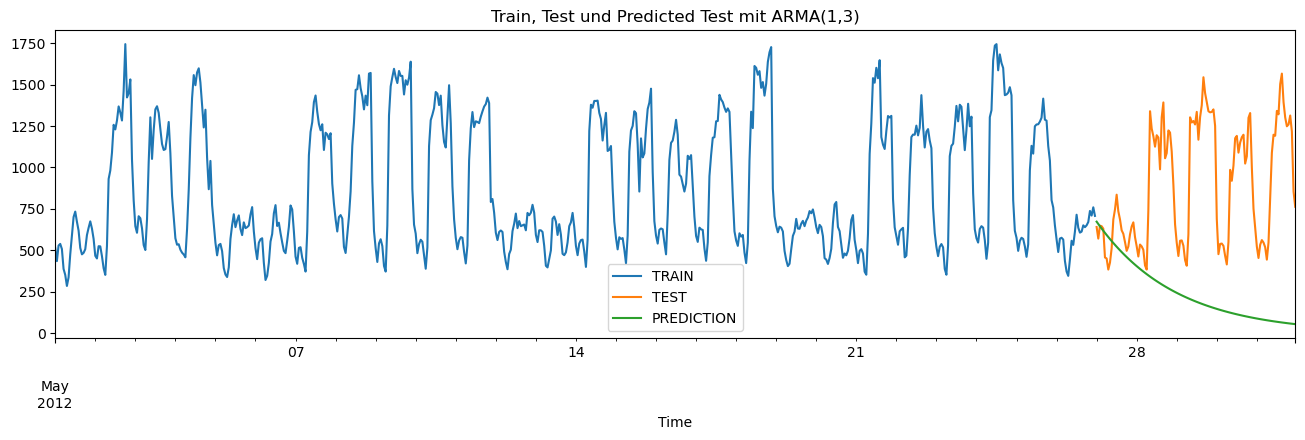

In [58]:
for_pred = for_results.get_forecast(steps=120)
train_em['Electricity'].plot(legend=True,label='TRAIN')
test_em['Electricity'].plot(legend=True,label='TEST',figsize=(16,4))
for_pred.predicted_mean.plot(legend=True,label='PREDICTION')
plt.title('Train, Test und Predicted Test mit ARMA(1,3)');

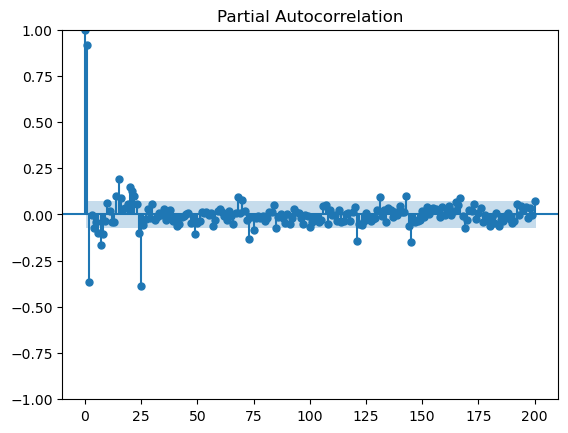

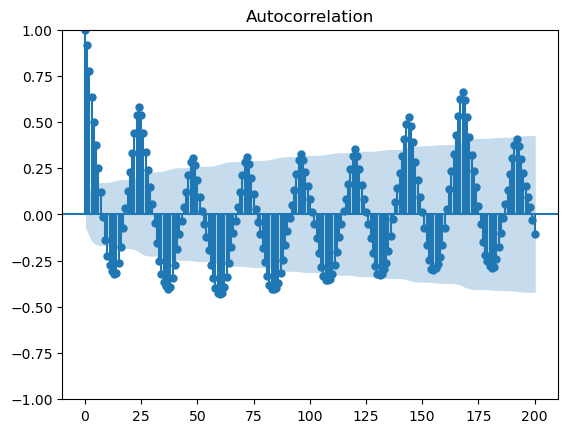

In [59]:
plot_pacf(em, lags=200, method='ywm');plot_acf(em, lags=200);

In [65]:
#warnings.filterwarnings("ignore")
for_mod = SARIMAX(train_em, 
              order=(2, 0, 0), 
              seasonal_order=(1, 0, 1, 24))
for_results = for_mod.fit()
print(for_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0298      0.032     31.700      0.000       0.966       1.093
ar.L2         -0.0949      0.034     -2.827      0.005      -0.161      -0.029
ar.S.L24       0.9995      0.002    542.916      0.000       0.996       1.003
ma.S.L24      -0.9653      0.057    -17.020      0.000      -1.076      -0.854
sigma2      1.156e+04    689.004     16.776      0.000    1.02e+04    1.29e+04


In [20]:
for_mod = SARIMAX(train_em, 
              order=(2, 0, 3), 
              seasonal_order=(1, 0, 1, 24))
for_results = for_mod.fit()
print(for_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7046      0.081     21.153      0.000       1.547       1.863
ar.L2         -0.7055      0.080     -8.773      0.000      -0.863      -0.548
ma.L1         -0.9688      0.089    -10.931      0.000      -1.143      -0.795
ma.L2         -0.0287      0.052     -0.547      0.584      -0.132       0.074
ma.L3          0.0368      0.060      0.616      0.538      -0.080       0.154
ar.S.L24       0.9912      0.004    279.986      0.000       0.984       0.998
ma.S.L24      -0.8370      0.028    -29.530      0.000      -0.893      -0.781
sigma2       224.7807     10.981     20.470      0.000     203.259     246.303


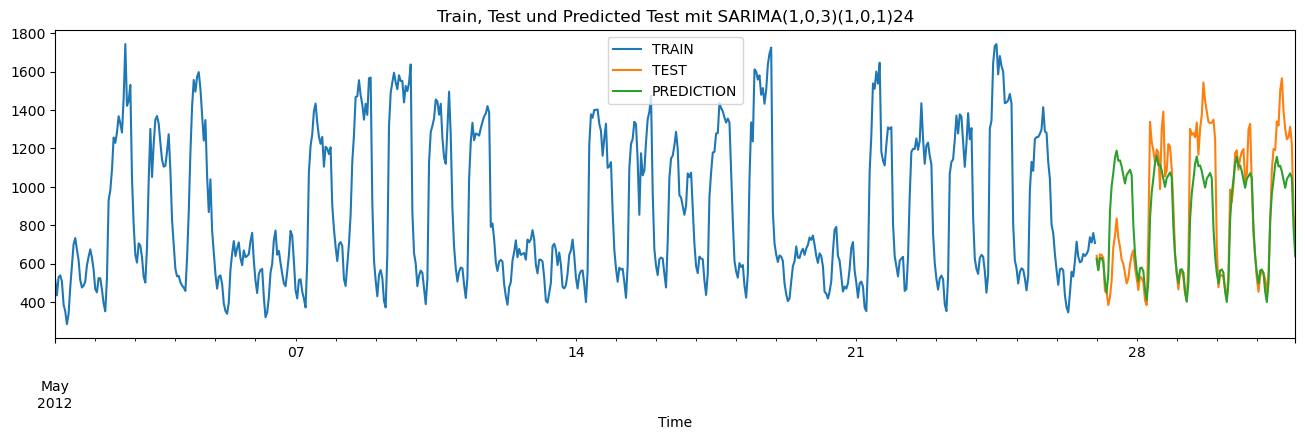

In [66]:
for_pred = for_results.get_forecast(steps=120)
train_em['Electricity'].plot(legend=True,label='TRAIN')
test_em['Electricity'].plot(legend=True,label='TEST',figsize=(16,4))
for_pred.predicted_mean.plot(legend=True,label='PREDICTION')
plt.title('Train, Test und Predicted Test mit SARIMA(1,0,3)(1,0,1)24');

Zur Validierung des Modells z.B. prüfen, ob die Residuen, also die geschätzten $\epsilon_t$, unkorreliert sind und sich wie weißes Rauschen verhalten.

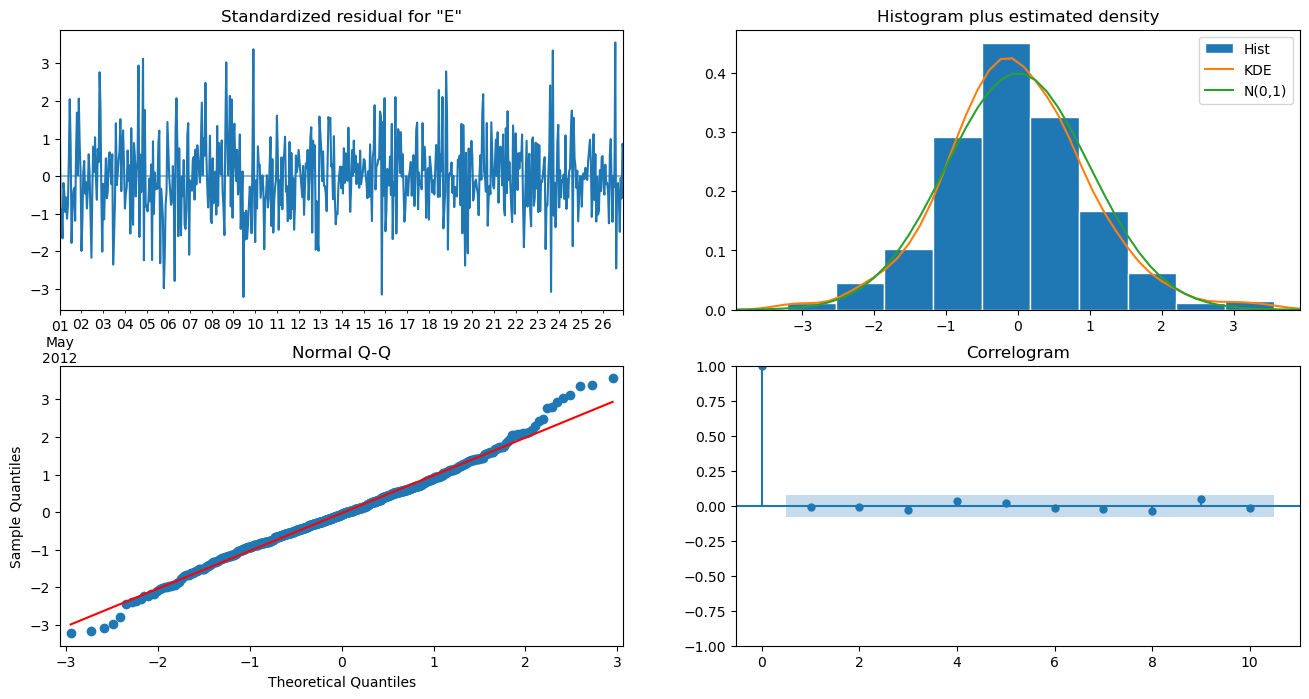

In [51]:
for_results.plot_diagnostics(figsize=(16, 8))
plt.show()

<h3>How good is my model?</h3>

Reminder:<br>
Mean Absolute Error Holt-Winter = 87<br>
Mean Squared Error Holt-Winter = 11600

In [52]:
y_tru = test_em
y_SARIMA = for_pred.predicted_mean
errors = [['Mean Absolute Error', 87, mean_absolute_error(y_tru,y_SARIMA)], ['Mean Squared Error', 11600, mean_squared_error(y_tru,y_SARIMA)]] 
errors = pd.DataFrame(errors, columns = ['Art des Fehlers','Holt-Winters Vorhersage','SARIMA Vorhersage']) 
errors.set_index('Art des Fehlers', inplace=True) 
errors = round(errors, 2)
errors 

,Holt-Winters Vorhersage,SARIMA Vorhersage
Art des Fehlers,,
Mean Absolute Error,87,17.43
Mean Squared Error,11600,621.19


<h3> Model identification: Determine (p,d,q)(P,D,Q)  </h3>
You can determine the parameters even more systematically - or have them determined

In [ ]:
# -> dauert evtl lange (ca. 1-2 Min)...
warnings.filterwarnings("ignore")
p = q = range(0, 3)
d = 0
pdq = list(itertools.product(p, [d], q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, [d], q))]
print(pdq)
print(seasonal_pdq)
df = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = SARIMAX(train_em,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        d = {
            'non-seasonal' : param,
            'seasonal' : param_seasonal,
            'AIC' : results.aic
        }
        df.append(d)
df = pd.DataFrame(df)
df['AIC'] = df['AIC'].astype(float)
df.to_csv('pdqPDQ.csv') 

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2)]
[(0, 0, 0, 24), (0, 0, 1, 24), (0, 0, 2, 24), (1, 0, 0, 24), (1, 0, 1, 24), (1, 0, 2, 24), (2, 0, 0, 24), (2, 0, 1, 24), (2, 0, 2, 24)]


In [ ]:
pdq = pd.read_csv("pdqPDQ.csv")
pdq = pdq.drop(columns=['Unnamed: 0'])
print('Beispiele...')
print(pdq.head())
print('Minimum AIC bei')
print(pdq[ pdq['AIC'] == pdq['AIC'].min() ])

<div class="alert alert-info">
- Perform a SARIMA prediction for our test period using the proposed model<br>
(- Plot the results of your prediction in the plot above (so that you also have the SARIMA results with manually determined parameters in the same plot).))<br>
(- Adjust the labels so that it is clear which line is what)<br>
- What does it look like? Can you tell the difference?<br>
- Determine the error measures for your analysis and add them to the table above<br>
- Which SARIMA analysis performs better? Why do you think that is?
</div>

In [ ]:
for_mod0 = SARIMAX(train_em, 
              order=(1, 1, 1), 
              seasonal_order=(1, 1, 1, 24))
for_results0 = for_mod0.fit()
print(for_results0.summary().tables[1])

In [ ]:
for_pred0 = for_results0.get_forecast(steps=120)
train_em['Electricity'].plot(legend=True,label='TRAIN')
test_em['Electricity'].plot(legend=True,label='TEST',figsize=(16,4))
for_pred0.predicted_mean.plot(legend=True,label='PREDICTION')
plt.title('Train, Test und Predicted Test mit SARIMA(1,1,1)(1,1,1)24');

In [ ]:
for_mod1 = SARIMAX(train_em, 
              order=(2, 0, 3), 
              seasonal_order=(1, 0, 1, 24))
for_results1 = for_mod1.fit()
print(for_results1.summary().tables[1])

In [ ]:
for_pred1 = for_results1.get_forecast(steps=120)
train_em['Electricity'].plot(legend=True,label='TRAIN')
test_em['Electricity'].plot(legend=True,label='TEST',figsize=(16,4))
for_pred1.predicted_mean.plot(legend=True,label='PREDICTION')
for_pred0.predicted_mean.plot(legend=True,label='PREDICTION_new')
plt.title('Train, Test und Predicted Test mit SARIMA-Modellen');

In [ ]:
y_tru = test_em
y_SARIMA0 = for_pred0.predicted_mean
y_SARIMA1 = for_pred1.predicted_mean
errors = [['Mean Absolute Error', mean_absolute_error(y_tru,y_SARIMA1), mean_absolute_error(y_tru,y_SARIMA0)], ['Mean Squared Error', mean_squared_error(y_tru,y_SARIMA1), mean_squared_error(y_tru,y_SARIMA0)]] 
errors = pd.DataFrame(errors, columns = ['Art des Fehlers','Händische SARIMA Vorhersage','Automatische SARIMA Vorhersage']) 
errors.set_index('Art des Fehlers', inplace=True) 
errors = round(errors, 2)
errors 